# Descarga datos

In [ ]:
import requests
from pandas.io.json import json_normalize
import pandas as pd

url="https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=1000000000"
Datos=pd.read_json(url,convert_dates=['fecha_de_notificaci_n','fecha_de_muerte','fis','fecha_diagnostico','fecha_recuperado','fecha_reporte_web'])

In [ ]:
Datos.rename(columns={'id_de_caso':'id_caso','fecha_de_notificaci_n':'fecha_notificacion','c_digo_divipola':'codigo_municipio','ciudad_de_ubicaci_n':'ciudad',
                      'atenci_n':'atencion','tipo':'tipo_contagio','estado':'estado','pa_s_de_procedencia':'pais_procedencia','fis':'fecha_sintomas',
                      'tipo_recuperaci_n':'tipo_recuperacion','fecha_de_muerte':'fecha_muerte'},inplace=True)

In [ ]:
Datos

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaT
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09,2020-03-19,2020-03-09,PCR,76,724.0,Otro,NaN,NaT
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaT
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658451,658492,2020-08-22,5001,Medellín,Antioquia,Casa,18,M,En estudio,Leve,NaN,2020-08-18T00:00:00.000,2020-09-02,NaT,2020-09-05,NaN,5,NaN,NaN,NaN,NaT
658452,658493,2020-08-22,66001,Pereira,Risaralda,Casa,48,F,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-02,NaT,2020-09-05,NaN,66,NaN,NaN,NaN,NaT
658453,658494,2020-08-23,5001,Medellín,Antioquia,Casa,31,F,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-05,NaN,5,NaN,NaN,NaN,NaT
658454,658495,2020-08-24,25754,Soacha,Cundinamarca,Casa,18,F,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-04,NaT,2020-09-05,NaN,25,NaN,NaN,NaN,NaT


# Análisis datos y dataset final para modelar

In [ ]:
# Cuenta vacíos
Datos.isna().sum()

id_caso                     0
fecha_notificacion          0
codigo_municipio            0
ciudad                      0
departamento                0
atencion                    0
edad                        0
sexo                        0
tipo_contagio               0
estado                      0
pais_procedencia       657491
fecha_sintomas              0
fecha_diagnostico        3980
fecha_recuperado       150681
fecha_reporte_web           0
tipo_recuperacion      150686
codigo_departamento         0
codigo_pais            657495
pertenencia_etnica     375001
nombre_grupo_etnico    647131
fecha_muerte           635949
dtype: int64

In [ ]:
# 5 principales ciudades: Bogotá, Medellín, Cali, Barranquilla y Cartagena de Indias, coincide con las de más casos
Datos['ciudad'].value_counts().head(10)

Bogotá D.C.            223522
Medellín                50942
Cali                    38887
Barranquilla            36611
Cartagena de Indias     20815
Soledad                 13936
Montería                12705
Valledupar               9481
Bucaramanga              9255
Soacha                   9012
Name: ciudad, dtype: int64

In [ ]:
# filtrando ciudades
Datos1=Datos[Datos['ciudad'].isin(['Cali'])]
Datos1.reset_index(inplace=True,drop=True)
Datos1

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,25,2020-03-13,76001,Cali,Valle del Cauca,Recuperado,49,M,Importado,Leve,ESPAÑA,2020-03-10T00:00:00.000,2020-03-13,2020-05-12,2020-03-13,PCR,76,724.0,Otro,NaN,NaT
1,62,2020-03-14,76001,Cali,Valle del Cauca,Recuperado,32,M,Importado,Leve,ITALIA,2020-03-12T00:00:00.000,2020-03-16,2020-03-26,2020-03-16,PCR,76,380.0,Otro,NaN,NaT
2,63,2020-03-16,76001,Cali,Valle del Cauca,Recuperado,26,F,Importado,Leve,FRANCIA,2020-03-14T00:00:00.000,2020-03-16,2020-03-28,2020-03-16,PCR,76,250.0,Otro,NaN,NaT
3,81,2020-03-17,76001,Cali,Valle del Cauca,Recuperado,49,F,Importado,Leve,ESTADOS UNIDOS,2020-03-14T00:00:00.000,2020-03-17,2020-03-28,2020-03-17,PCR,76,840.0,Otro,NaN,NaT
4,82,2020-03-16,76001,Cali,Valle del Cauca,Recuperado,54,M,Importado,Leve,ESPAÑA,2020-03-14T00:00:00.000,2020-03-17,2020-04-19,2020-03-17,PCR,76,724.0,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38882,658341,2020-08-24,76001,Cali,Valle del Cauca,Casa,20,F,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-04,NaT,2020-09-05,NaN,76,NaN,NaN,NaN,NaT
38883,658343,2020-08-24,76001,Cali,Valle del Cauca,Casa,18,F,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-04,NaT,2020-09-05,NaN,76,NaN,NaN,NaN,NaT
38884,658346,2020-08-24,76001,Cali,Valle del Cauca,Casa,18,M,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-04,NaT,2020-09-05,NaN,76,NaN,NaN,NaN,NaT
38885,658381,2020-08-24,76001,Cali,Valle del Cauca,Casa,19,F,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-04,NaT,2020-09-05,NaN,76,NaN,NaN,NaN,NaT


# **Metodologías propuestas y desarrollo de los modelos**

## Metodología 1: Nuevos ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

In [ ]:
tabla_nuevos

,fecha_reporte_web,casos_nuevos_reportados,casos_confirmados
0,2020-03-13,1,1
1,2020-03-16,2,3
2,2020-03-17,5,8
3,2020-03-20,1,9
4,2020-03-21,6,15
...,...,...,...
163,2020-08-28,368,35895
164,2020-08-29,326,36221
165,2020-08-30,334,36555
166,2020-08-31,309,36864


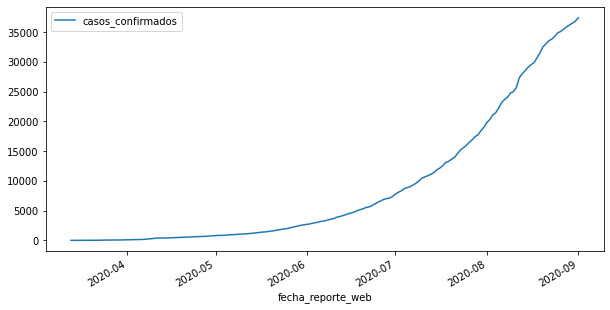

In [ ]:
# los casos confirmados no pueden ser con modelo basado en la tendencia, se tiene que predecir con el resultado de la suma de los casos nuevos reportados
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_confirmados',figsize=(10, 5)).figure.savefig('1.png')

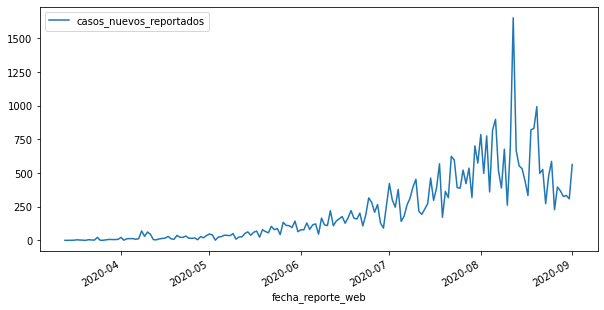

In [ ]:
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_nuevos_reportados',figsize=(10, 5)).figure.savefig('2.png')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


mean1=42.261905, mean2=403.309524
variance1=1559.740930, variance2=61968.118481


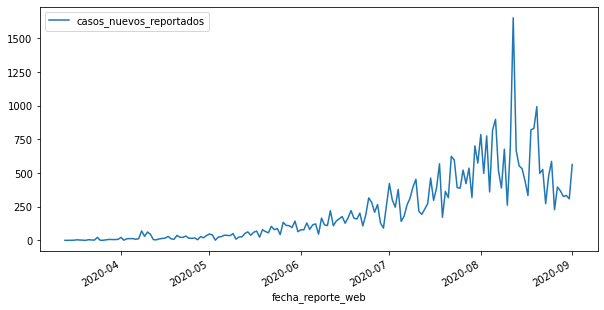

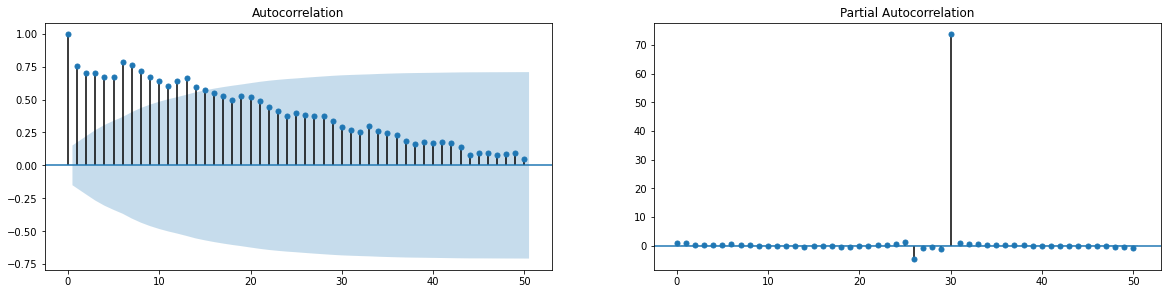

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M1Nuevos=M1Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M1Nuevos.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Nuevos.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Nuevos, lags=50, ax=ax2)

X=M1Nuevos.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=3.155085, mean2=5.829594
variance1=1.607710, variance2=0.346726


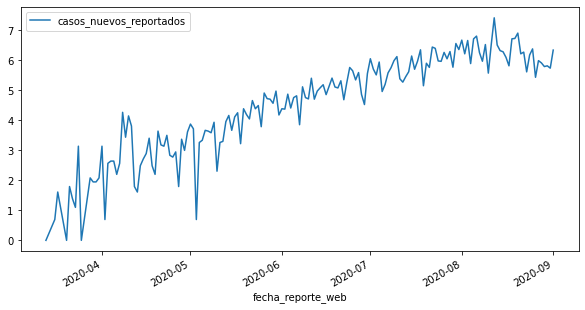

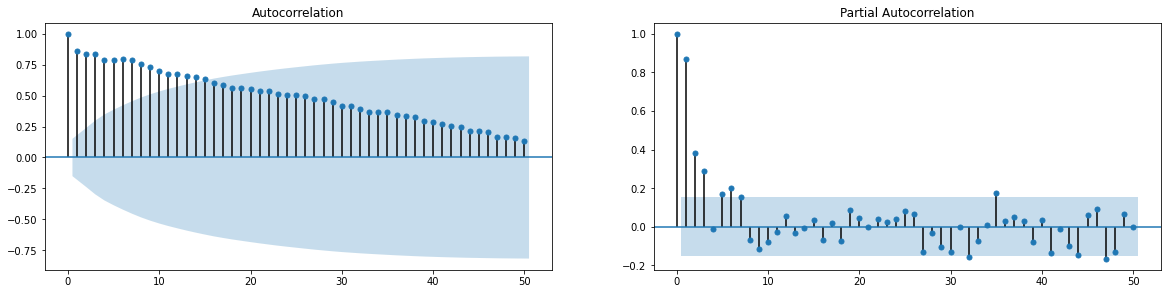

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1NuevosLog=np.log(M1Nuevos)
plt.rcParams["figure.figsize"] = (10,5)
M1NuevosLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLog, lags=50, ax=ax2)

X=M1NuevosLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

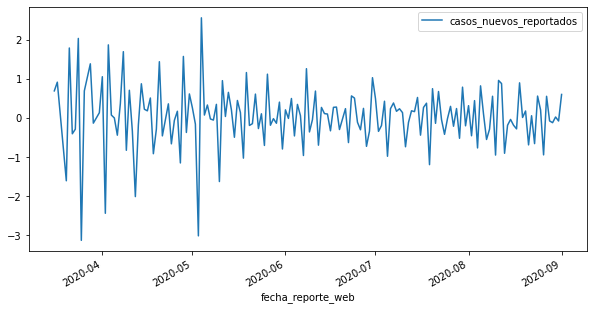

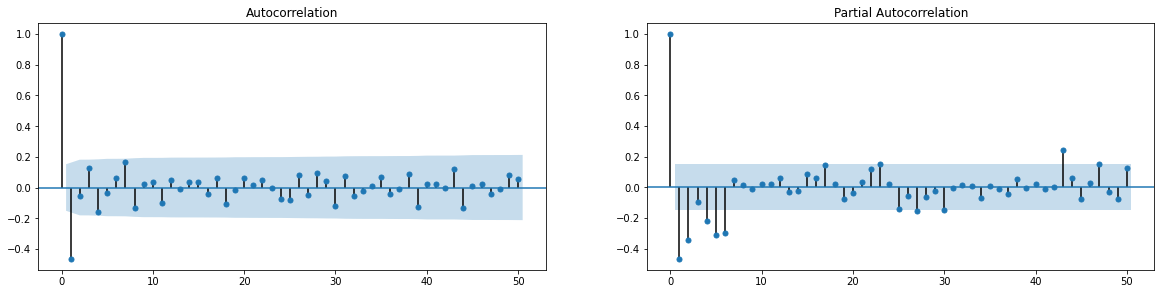

In [ ]:
# Primera diferencia para volver estacional
M1NuevosLogDif=M1NuevosLog.diff()
M1NuevosLogDif=M1NuevosLogDif[1:]
M1NuevosLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(168, 1)
(134, 1)
(20, 1)
(14, 1)


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 2.1MB 18.3MB/s 
     |████████████████████████████████| 9.5MB 32.6MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -128.583
Date:                Wed, 02 Sep 2020   AIC                            263.165
Time:                        18:55:21   BIC                            271.836
Sample:                             0   HQIC                           266.689
                                - 134                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0391      0.010      4.007      0.000       0.020       0.058
ma.L1         -0.8723      0.036    -24.054      0.000      -0.943      -0.801
sigma2         0.4005      0.033     12.167      0.000       0.336       0.465
===================================================================================
Ljung-Box (Q):                       50.09   Jarque-Bera (JB):                58.12
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


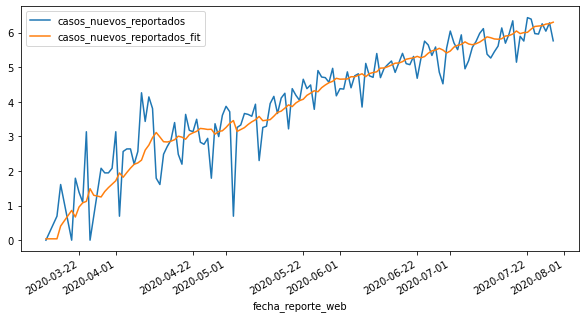

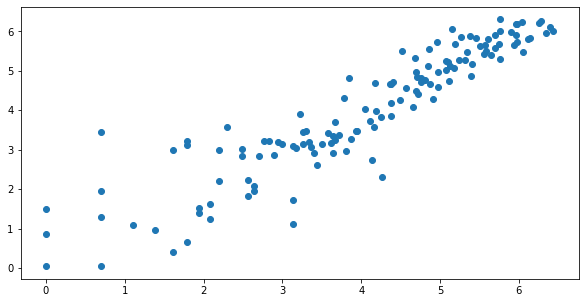

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


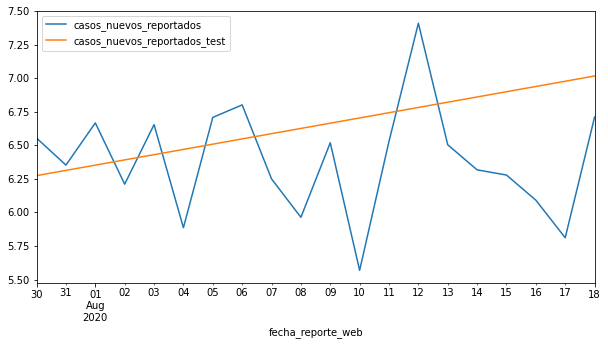

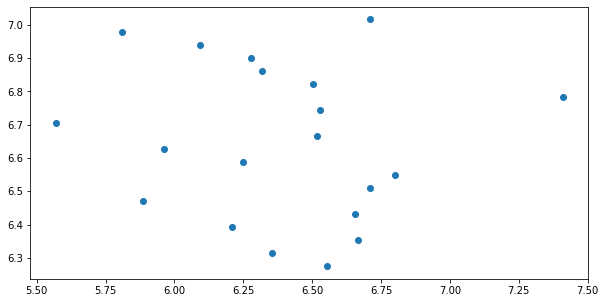

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5)).figure.savefig('3.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.savefig('4.png')
plt.show()


M1NuevosLogTest['casos_nuevos_reportados_test']=arima.predict(n_periods=(len(M1NuevosLogTest))) 
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5)).figure.savefig('5.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.savefig('6.png')
plt.show()

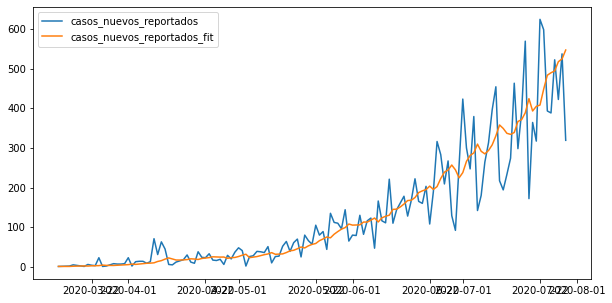

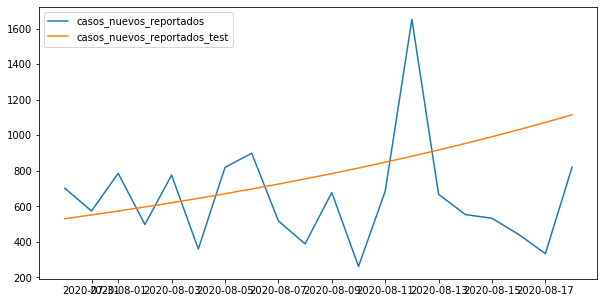

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fit'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fit'])
plt.savefig('7.png')
plt.show()

FM1NuevosTest=np.exp(M1NuevosLogTest)
plt.plot(FM1NuevosTest['casos_nuevos_reportados'])
plt.plot(FM1NuevosTest['casos_nuevos_reportados_test'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_test'])
plt.savefig('8.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Nuevos['casos_nuevos_reportados'],FM1Nuevos['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1NuevosTest['casos_nuevos_reportados'],FM1NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)


MSE in train: 4230.223626
MSE in test: 138879.426135


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(166, 1)
(132, 1)
(20, 1)
(14, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


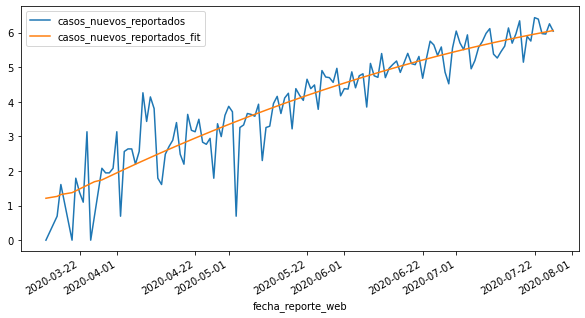

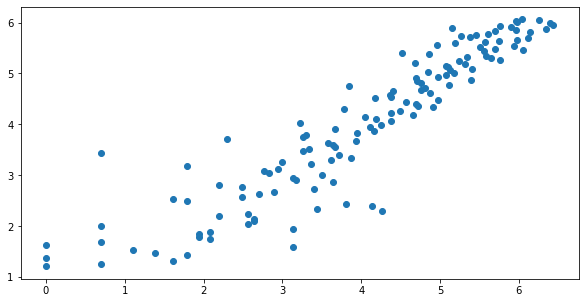

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


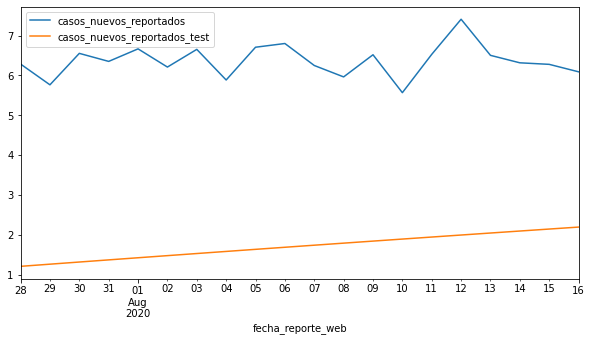

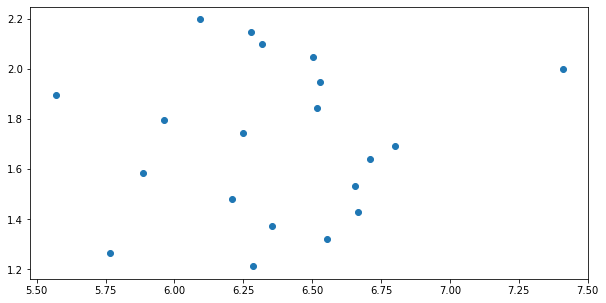

Mean squared error: 0.38
Variance score: 0.84


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1NuevosLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1NuevosLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1NuevosLogTrain['casos_nuevos_reportados'].values.reshape(-1,1))
M1NuevosLogTrain['casos_nuevos_reportados_fit']=model.predict(x_trainpoly)

plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.show()

M1NuevosLogTest['casos_nuevos_reportados_test']=model.predict(x_testpoly)
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])))

print('Variance score: %.2f' % r2_score(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit']))

#4,3,2
#Mean squared error: 0.15, 0.19, 0.24
#Variance score: 0.96, 0.95, 0.94

# LinnearRegression() 0.24, 0.94

In [ ]:
M1NuevosLogTrain['Errores']=M1NuevosLogTrain['casos_nuevos_reportados']-M1NuevosLogTrain['casos_nuevos_reportados_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:                        SARIMAX   Log Likelihood                -122.754
Date:                Tue, 01 Sep 2020   AIC                            247.507
Time:                        03:18:34   BIC                            250.390
Sample:                             0   HQIC                           248.679
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3761      0.028     13.615      0.000       0.322       0.430
===================================================================================
Ljung-Box (Q):                       54.10   Jarque-Bera (JB):                79.45
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


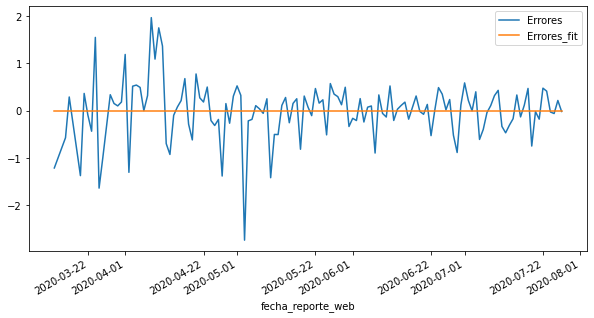

In [ ]:
M1NuevosLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


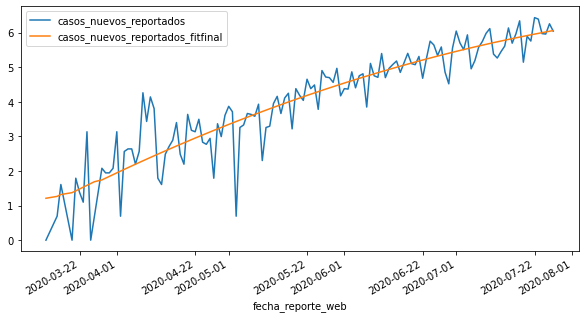

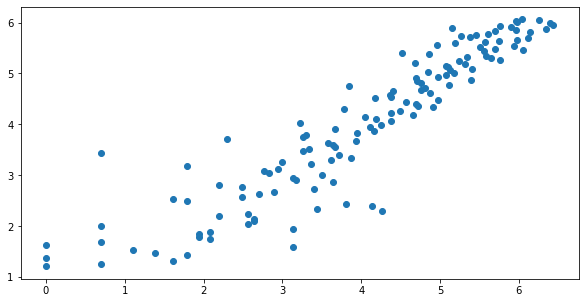

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fitfinal']=M1NuevosLogTrain['casos_nuevos_reportados_fit']+M1NuevosLogTrain['Errores_fit']
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


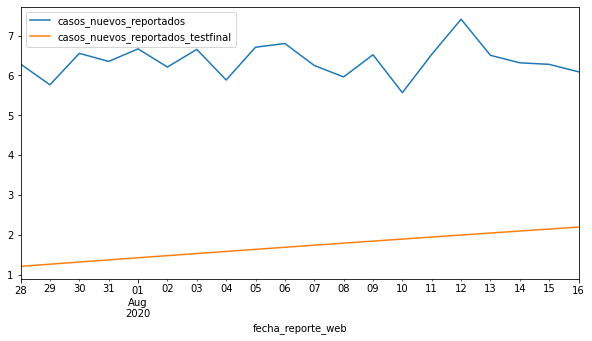

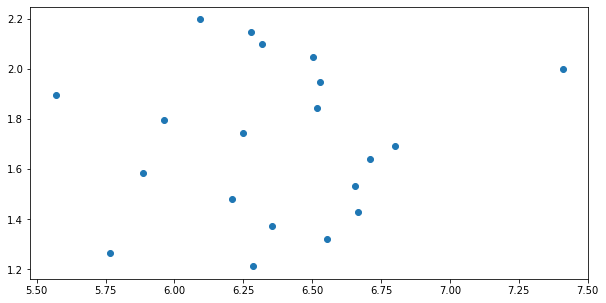

In [ ]:
M1NuevosLogTest['Errores_test']=arima.predict(n_periods=(len(M1NuevosLogTest)))
M1NuevosLogTest['casos_nuevos_reportados_testfinal']=M1NuevosLogTest['casos_nuevos_reportados_test']+M1NuevosLogTest['Errores_test']

plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_testfinal'])
plt.show() 

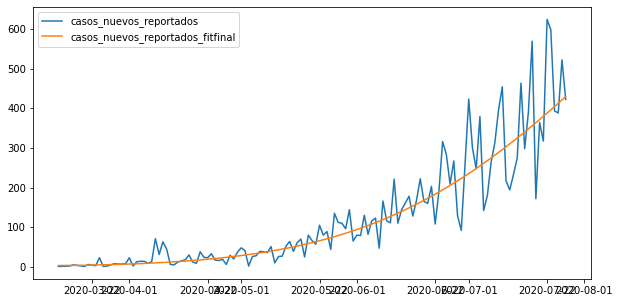

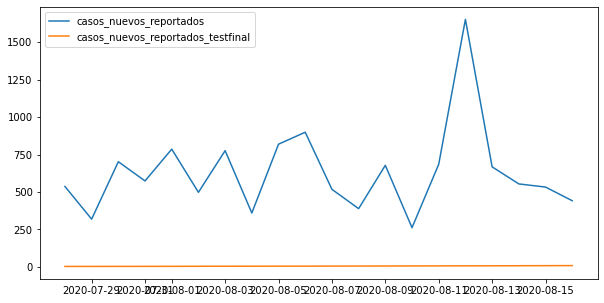

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fitfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fitfinal'])
plt.show()

FM1Nuevos=np.exp(M1NuevosLogTest)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_testfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Muerte ARIMA Y POLINOMIAL CON ERORRES ARIMA



In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

In [ ]:
tabla_muerte

,fecha_muerte,casos_muerte
0,2020-03-25,2
1,2020-03-30,1
2,2020-03-31,1
3,2020-04-03,1
4,2020-04-04,2
...,...,...
138,2020-08-28,17
139,2020-08-29,13
140,2020-08-30,19
141,2020-08-31,17


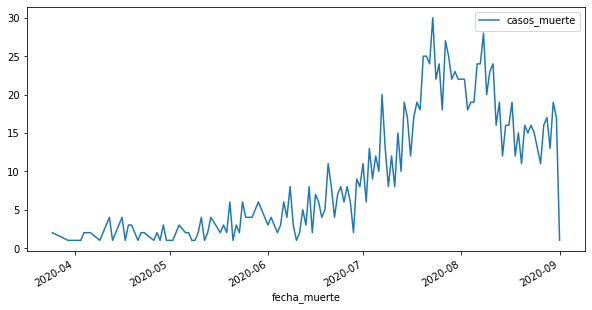

In [ ]:
tabla_muerte.plot(x='fecha_muerte',y='casos_muerte',figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


mean1=3.166667, mean2=16.028169
variance1=4.277778, variance2=40.844277


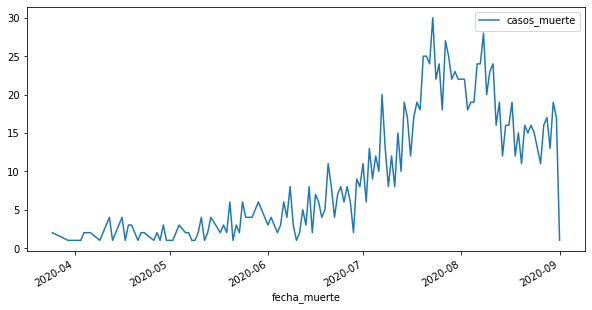

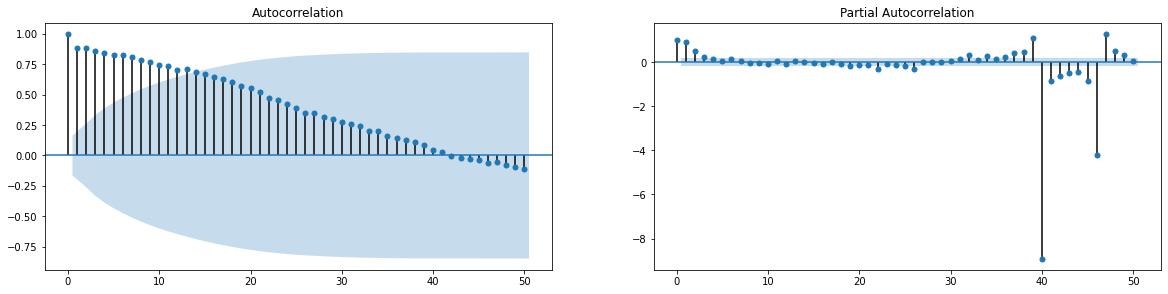

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M1Muerte.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Muerte.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Muerte, lags=50, ax=ax2)

X=M1Muerte.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.948253, mean2=2.657264
variance1=0.421860, variance2=0.319740


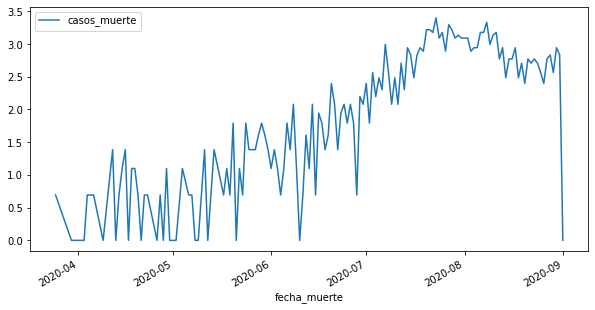

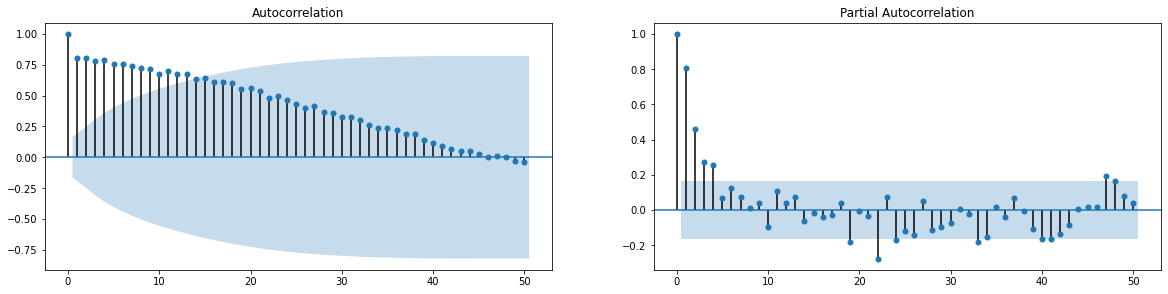

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1MuerteLog=np.log(M1Muerte)
plt.rcParams["figure.figsize"] = (10,5)
M1MuerteLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLog, lags=50, ax=ax2)

X=M1MuerteLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

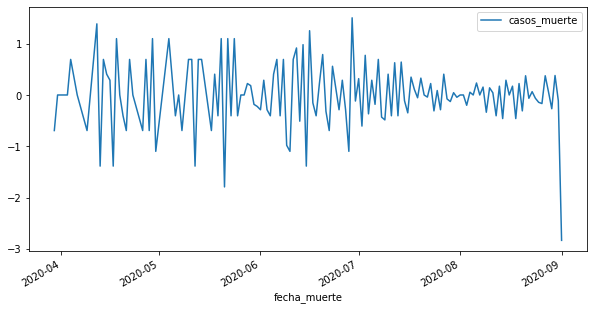

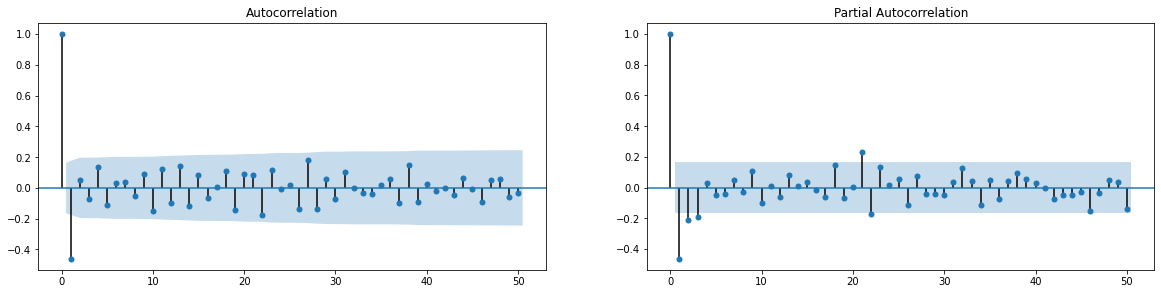

In [ ]:
# Primera diferencia para volver estacional
M1MuerteLogDif=M1MuerteLog.diff()
M1MuerteLogDif=M1MuerteLogDif[1:]
M1MuerteLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(143, 1)
(114, 1)
(17, 1)
(12, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -76.496
Date:                Wed, 02 Sep 2020   AIC                            158.993
Time:                        18:56:57   BIC                            167.175
Sample:                             0   HQIC                           162.313
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0258      0.007      3.542      0.000       0.012       0.040
ma.L1         -0.8683      0.055    -15.714      0.000      -0.977      -0.760
sigma2         0.2239      0.031      7.230      0.000       0.163       0.285
===================================================================================
Ljung-Box (Q):                       38.94   Jarque-Bera (JB):                 5.20
Prob(Q):                              0.52   Prob(JB):                         0.07
Heteroskedasticity (H):               0.43   Skew:                            -0.51
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


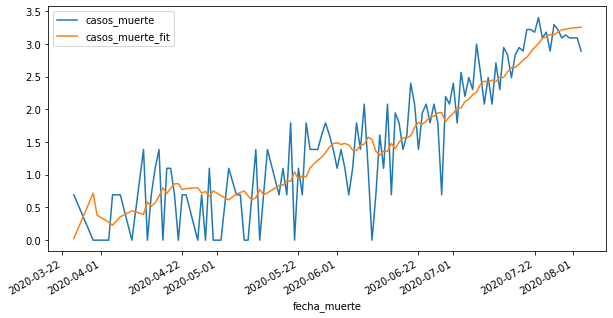

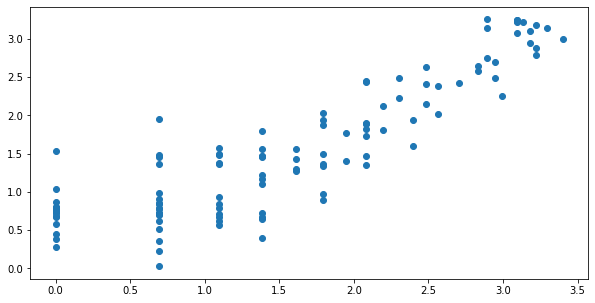

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


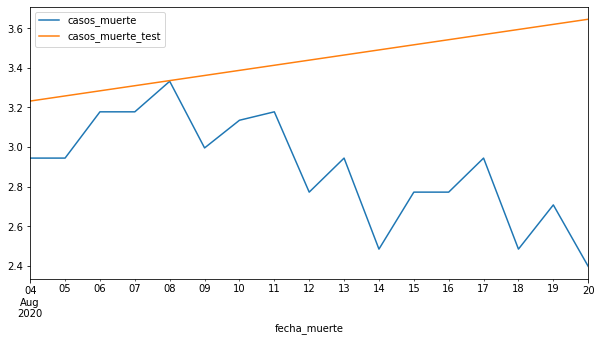

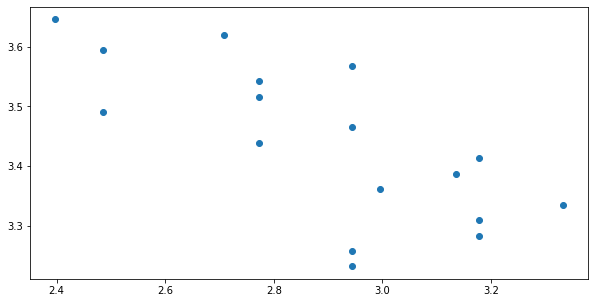

In [ ]:
M1MuerteLogTrain['casos_muerte_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()



M1MuerteLogTest['casos_muerte_test']=arima.predict(n_periods=(len(M1MuerteLogTest))) 
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

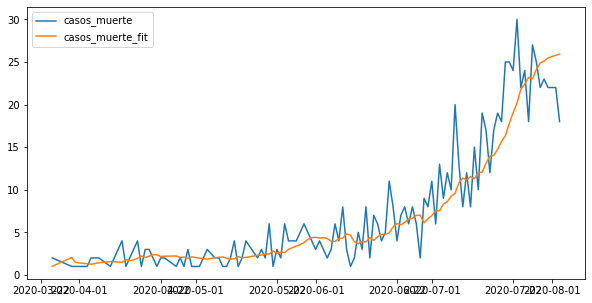

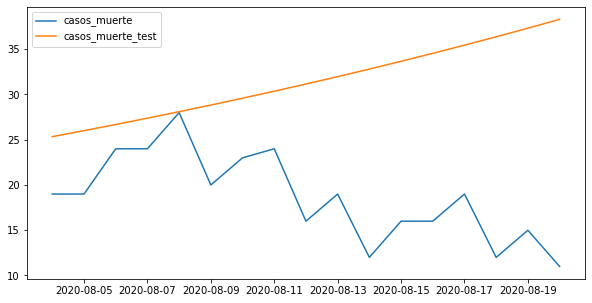

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fit'])
plt.legend(['casos_muerte','casos_muerte_fit'])
plt.show()

FM1MuerteTest=np.exp(M1MuerteLogTest)
plt.plot(FM1MuerteTest['casos_muerte'])
plt.plot(FM1MuerteTest['casos_muerte_test'])
plt.legend(['casos_muerte','casos_muerte_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Muerte['casos_muerte'],FM1Muerte['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1MuerteTest['casos_muerte'],FM1MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 8.594918
MSE in test: 227.343041


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(141, 1)
(112, 1)
(17, 1)
(12, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


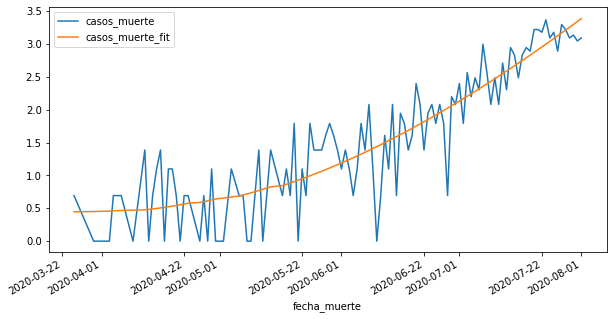

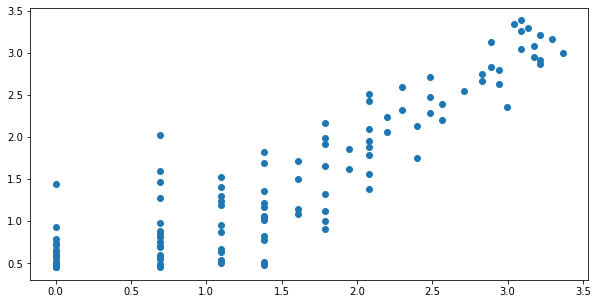

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


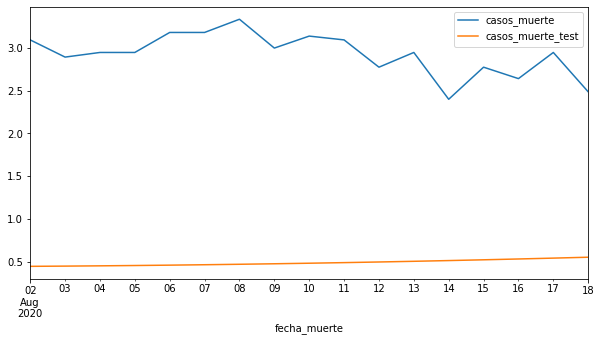

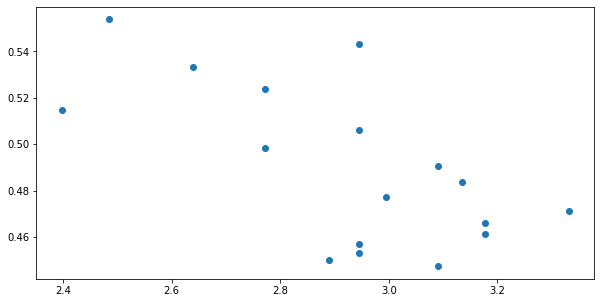

Mean squared error: 0.20
Variance score: 0.80


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1MuerteLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1MuerteLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=3)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1MuerteLogTrain['casos_muerte'].values.reshape(-1,1))
M1MuerteLogTrain['casos_muerte_fit']=model.predict(x_trainpoly)

plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()

M1MuerteLogTest['casos_muerte_test']=model.predict(x_testpoly)
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])))

print('Variance score: %.2f' % r2_score(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit']))

#3
#Mean squared error: 0.11
#Variance score: 0.94

# LinnearRegression()

In [ ]:
M1MuerteLogTrain['Errores']=M1MuerteLogTrain['casos_muerte']-M1MuerteLogTrain['casos_muerte_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  112
Model:                        SARIMAX   Log Likelihood                 -70.048
Date:                Tue, 01 Sep 2020   AIC                            142.096
Time:                        03:20:47   BIC                            144.814
Sample:                             0   HQIC                           143.199
                                - 112                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2045      0.025      8.077      0.000       0.155       0.254
===================================================================================
Ljung-Box (Q):                       41.72   Jarque-Bera (JB):                 4.98
Prob(Q):                              0.40   Prob(JB):                         0.08
Heteroskedasticity (H):               0.45   Skew:                            -0.49
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


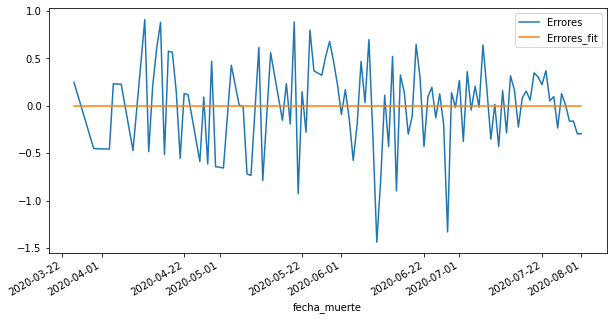

In [ ]:
M1MuerteLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


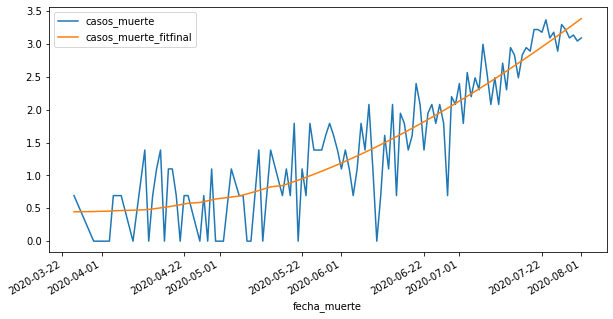

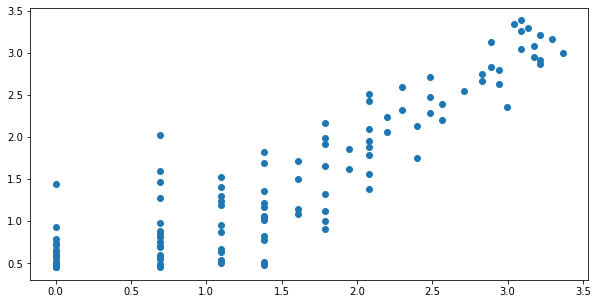

In [ ]:
M1MuerteLogTrain['casos_muerte_fitfinal']=M1MuerteLogTrain['casos_muerte_fit']+M1MuerteLogTrain['Errores_fit']
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


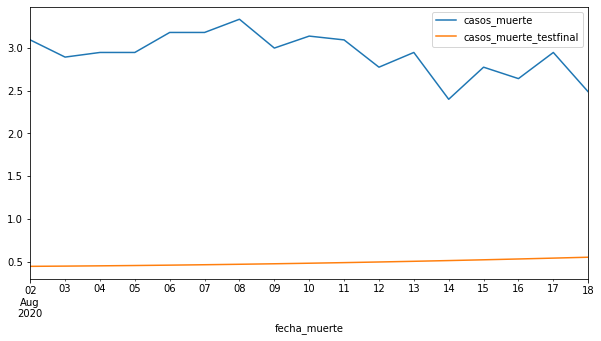

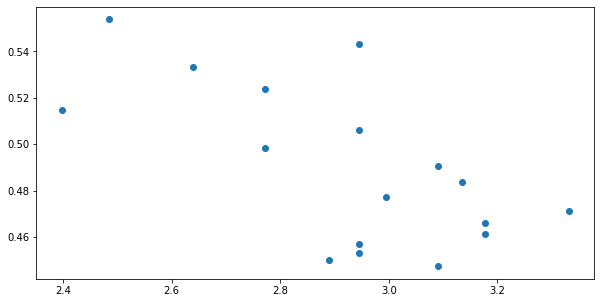

In [ ]:
M1MuerteLogTest['Errores_test']=arima.predict(n_periods=(len(M1MuerteLogTest)))
M1MuerteLogTest['casos_muerte_testfinal']=M1MuerteLogTest['casos_muerte_test']+M1MuerteLogTest['Errores_test']

plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_testfinal'])
plt.show() 

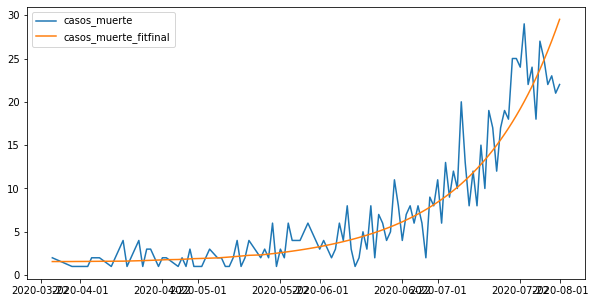

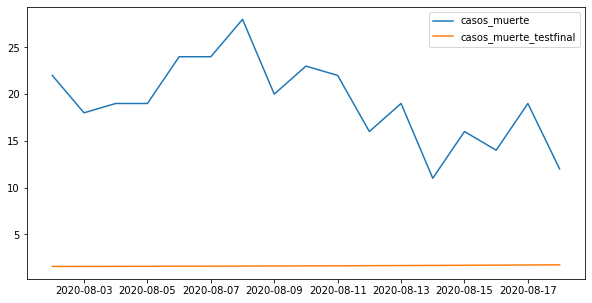

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fitfinal'])
plt.legend(['casos_muerte','casos_muerte_fitfinal'])
plt.show()

FM1Muerte=np.exp(M1MuerteLogTest)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_testfinal'])
plt.legend(['casos_muerte','casos_muerte_testfinal'])
plt.show()

#x_fore=M1MuerteLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Recuperado ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

In [ ]:
tabla_recuperado

,fecha_recuperado,casos_recuperado
0,2020-03-23,1
1,2020-03-26,2
2,2020-03-28,4
3,2020-03-30,1
4,2020-03-31,3
...,...,...
153,2020-08-28,511
154,2020-08-29,687
155,2020-08-30,628
156,2020-08-31,472


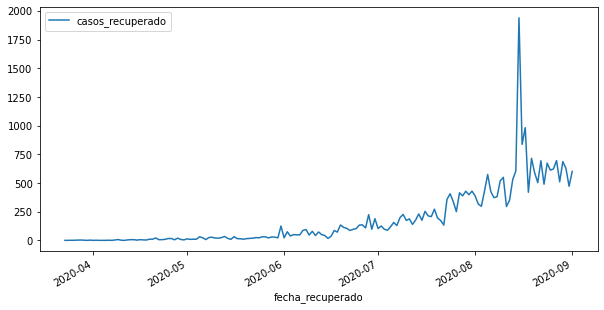

In [ ]:
tabla_recuperado.plot(x='fecha_recuperado',y='casos_recuperado',figsize=(10, 5))

mean1=22.569620, mean2=350.354430
variance1=579.916039, variance2=78174.887037


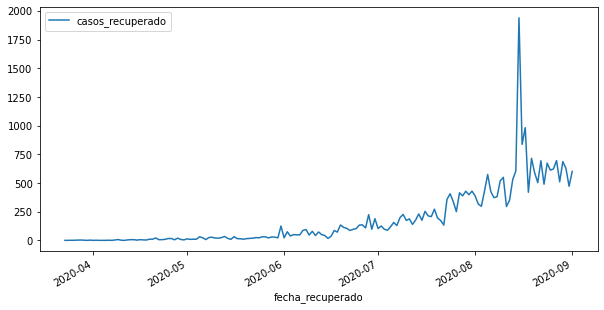

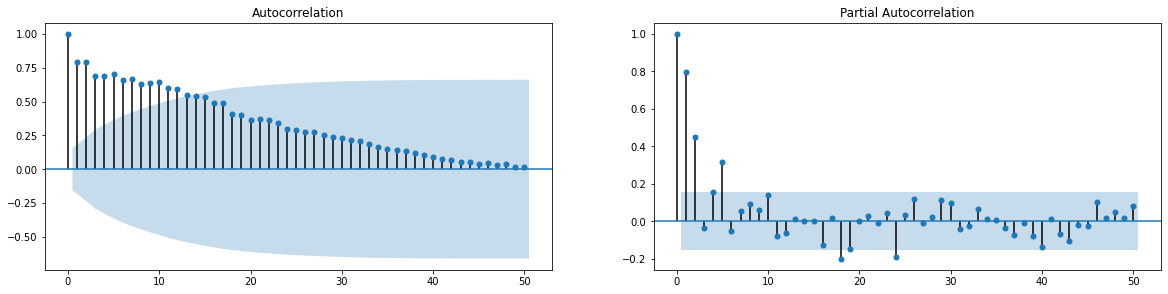

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M1Recuperado.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Recuperado.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Recuperado, lags=50, ax=ax2)

X=M1Recuperado.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=2.497300, mean2=5.569755
variance1=1.588361, variance2=0.644860


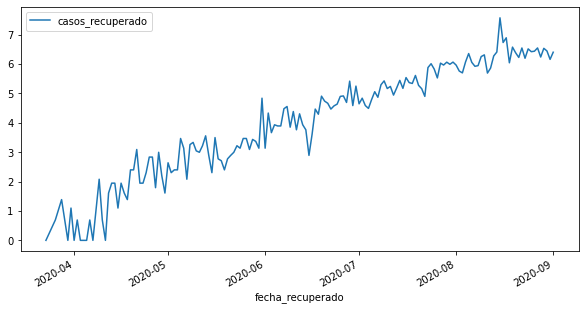

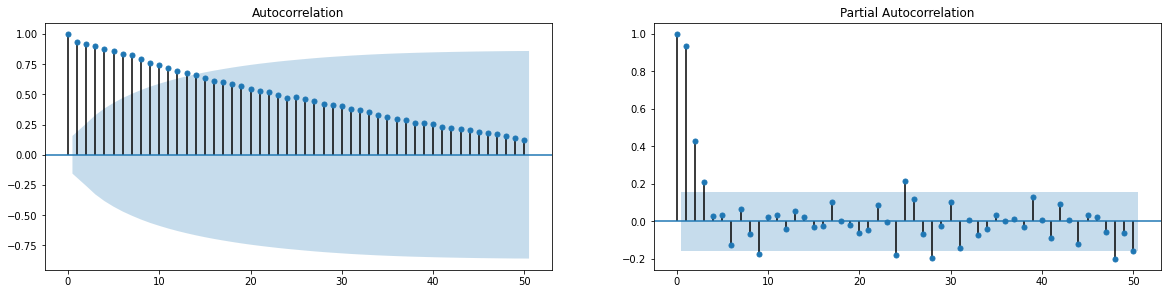

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1RecuperadoLog=np.log(M1Recuperado)
plt.rcParams["figure.figsize"] = (10,5)
M1RecuperadoLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLog, lags=50, ax=ax2)

X=M1RecuperadoLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

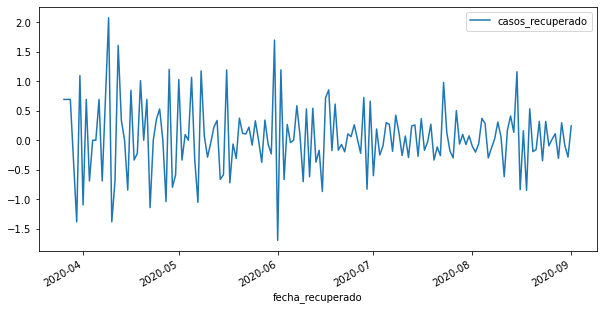

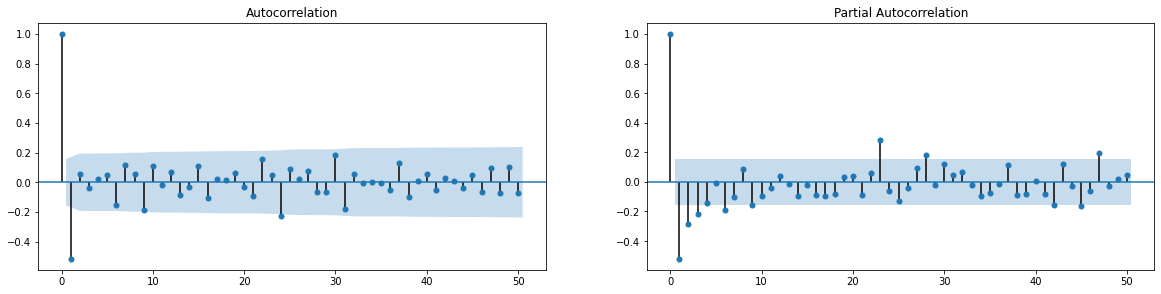

In [ ]:
# Primera diferencia para volver estacional
M1RecuperadoLogDif=M1RecuperadoLog.diff()
M1RecuperadoLogDif=M1RecuperadoLogDif[1:]
M1RecuperadoLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(158, 1)
(126, 1)
(19, 1)
(13, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -88.113
Date:                Wed, 02 Sep 2020   AIC                            182.227
Time:                        18:58:10   BIC                            190.712
Sample:                             0   HQIC                           185.674
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0456      0.010      4.793      0.000       0.027       0.064
ma.L1         -0.7999      0.051    -15.722      0.000      -0.900      -0.700
sigma2         0.2378      0.027      8.773      0.000       0.185       0.291
===================================================================================
Ljung-Box (Q):                       45.65   Jarque-Bera (JB):                 4.02
Prob(Q):                              0.25   Prob(JB):                         0.13
Heteroskedasticity (H):               0.19   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


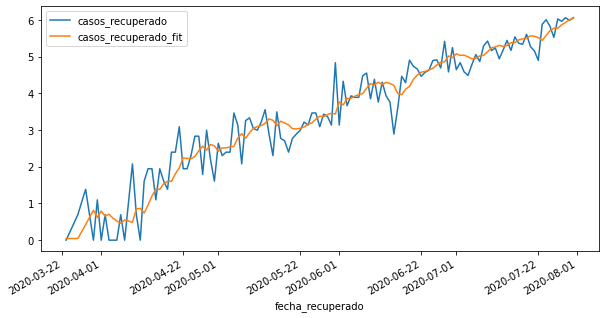

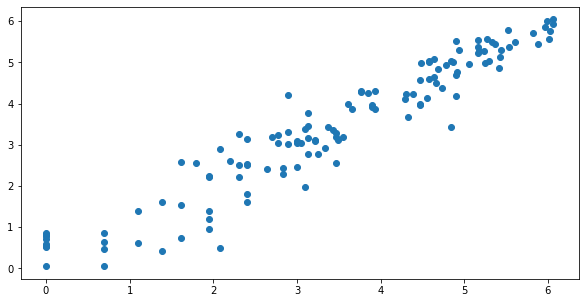

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


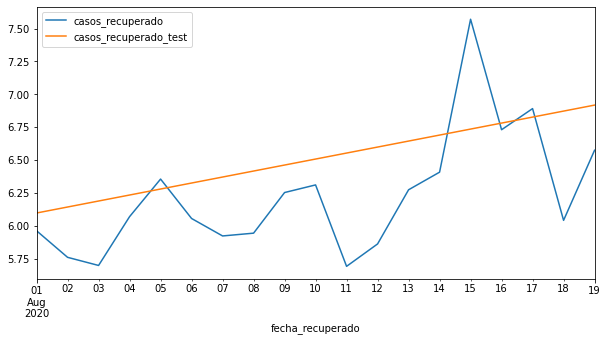

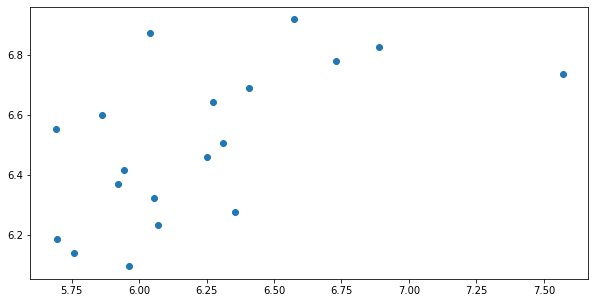

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()



M1RecuperadoLogTest['casos_recuperado_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest))) 
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

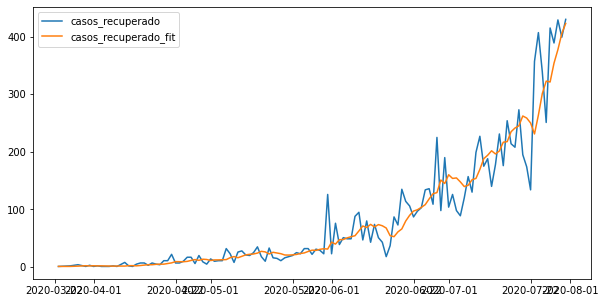

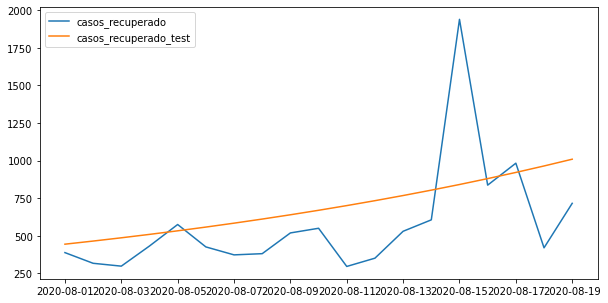

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fit'])
plt.legend(['casos_recuperado','casos_recuperado_fit'])
plt.show()

FM1RecuperadoTest=np.exp(M1RecuperadoLogTest)
plt.plot(FM1RecuperadoTest['casos_recuperado'])
plt.plot(FM1RecuperadoTest['casos_recuperado_test'])
plt.legend(['casos_recuperado','casos_recuperado_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Recuperado['casos_recuperado'],FM1Recuperado['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1RecuperadoTest['casos_recuperado'],FM1RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)


MSE in train: 1212.366297
MSE in test: 116514.974806


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(156, 1)
(124, 1)
(19, 1)
(13, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


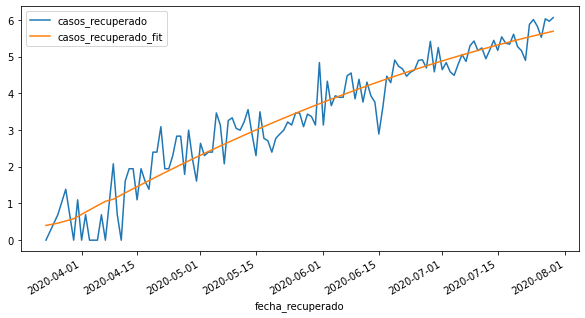

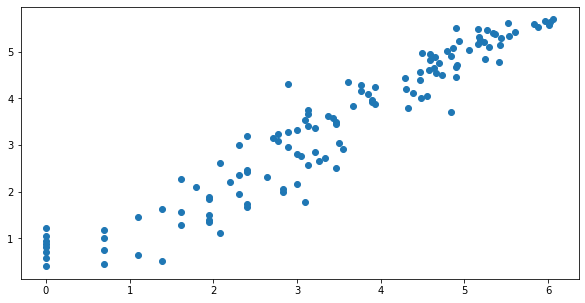

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


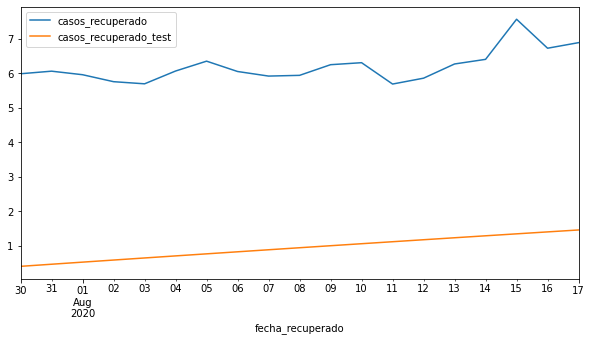

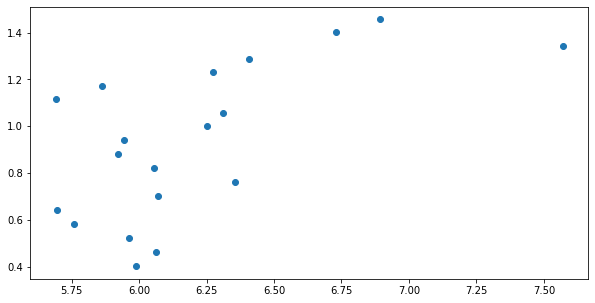

Mean squared error: 0.24
Variance score: 0.91


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1RecuperadoLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1RecuperadoLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1RecuperadoLogTrain['casos_recuperado'].values.reshape(-1,1))
M1RecuperadoLogTrain['casos_recuperado_fit']=model.predict(x_trainpoly)

plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()

M1RecuperadoLogTest['casos_recuperado_test']=model.predict(x_testpoly)
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])))

print('Variance score: %.2f' % r2_score(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit']))

#
#Mean squared error: 0.24
#Variance score: 0.94

# LinnearRegression() 

In [ ]:
M1RecuperadoLogTrain['Errores']=M1RecuperadoLogTrain['casos_recuperado']-M1RecuperadoLogTrain['casos_recuperado_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -83.118
Date:                Tue, 01 Sep 2020   AIC                            172.236
Time:                        03:22:52   BIC                            180.697
Sample:                             0   HQIC                           175.673
                                - 124                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7862      0.173      4.552      0.000       0.448       1.125
ma.L1         -0.6399      0.220     -2.903      0.004      -1.072      -0.208
sigma2         0.2236      0.028      8.123      0.000       0.170       0.278
===================================================================================
Ljung-Box (Q):                       44.78   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.28   Prob(JB):                         0.87
Heteroskedasticity (H):               0.21   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


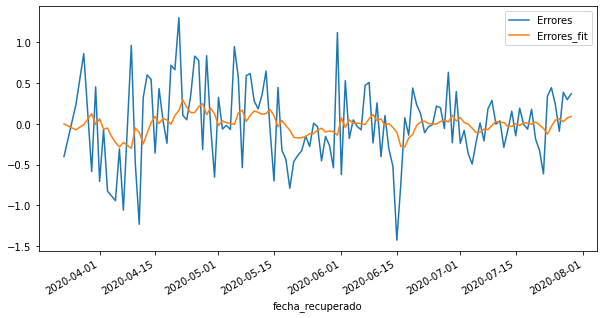

In [ ]:
M1RecuperadoLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


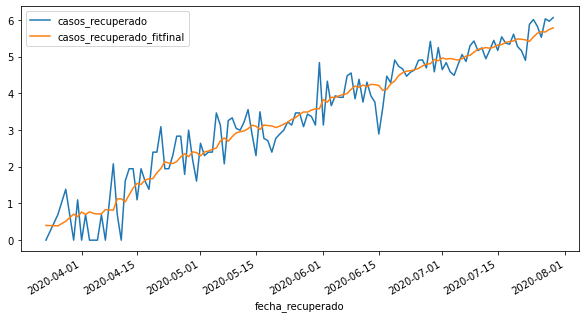

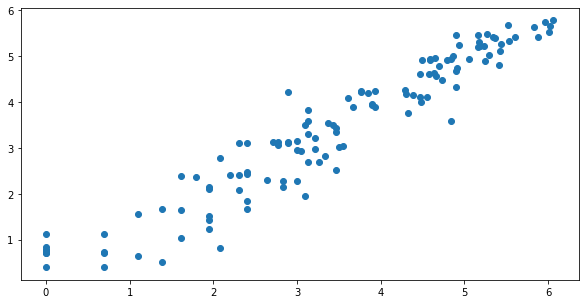

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fitfinal']=M1RecuperadoLogTrain['casos_recuperado_fit']+M1RecuperadoLogTrain['Errores_fit']
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


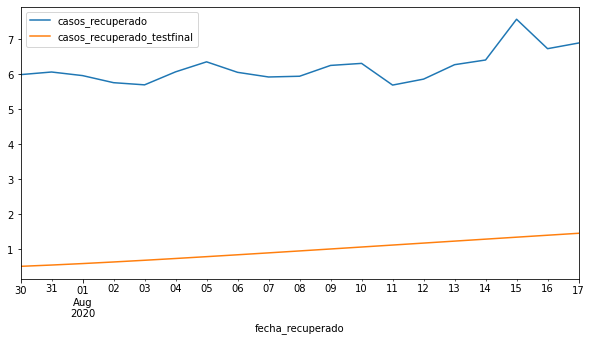

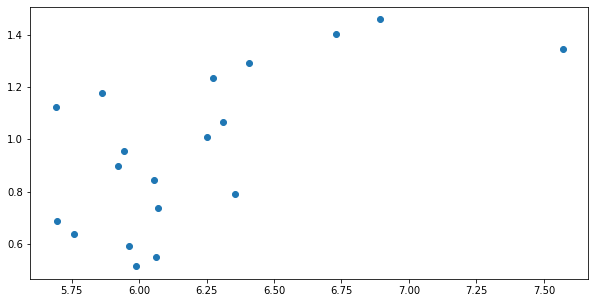

In [ ]:
M1RecuperadoLogTest['Errores_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest)))
M1RecuperadoLogTest['casos_recuperado_testfinal']=M1RecuperadoLogTest['casos_recuperado_test']+M1RecuperadoLogTest['Errores_test']

plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_testfinal'])
plt.show() 

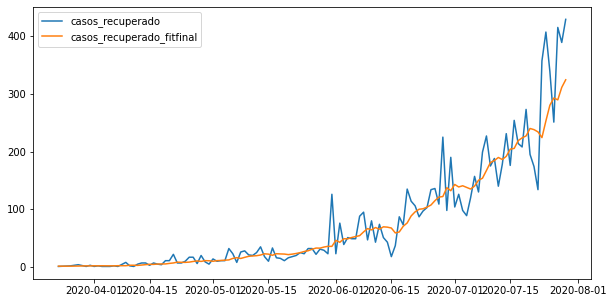

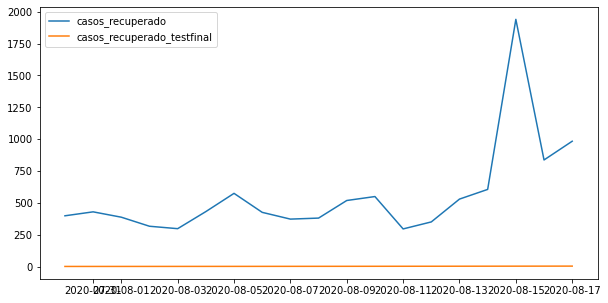

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fitfinal'])
plt.legend(['casos_recuperado','casos_recuperado_fitfinal'])
plt.show()

FM1Recuperado=np.exp(M1RecuperadoLogTest)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_testfinal'])
plt.legend(['casos_recuperado','casos_recuperado_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 2: Nuevos RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

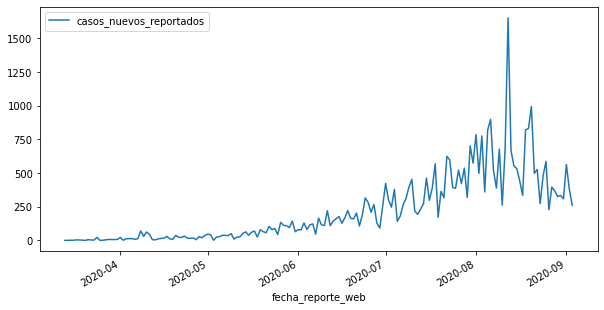

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M2Nuevos.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2NuevosTrain=M2Nuevos[:int(len(M2Nuevos)*p_train)]
M2NuevosTest=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]
M2NuevosForecast=M2Nuevos[int(len(M2Nuevos)*(p_train+p_test)):]
print(M2Nuevos.shape)
print(M2NuevosTrain.shape)
print(M2NuevosTest.shape)
print(M2NuevosForecast.shape)

(170, 1)
(136, 1)
(20, 1)
(14, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2NuevosTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2NuevosTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(129, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
5/5 [==============================] - 0s 20ms/step - loss: 0.0775
Epoch 2/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0363
Epoch 3/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0216
Epoch 4/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0113
Epoch 5/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0152
Epoch 6/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0101
Epoch 7/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0100
Epoch 8/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0126
Epoch 9/150
5/5 [==============================] - 0s 19ms/step - loss: 0.0103
Epoch 10/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0103
Epoch 11/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0098
Epoch 12/150
5/5 [==============================] - 0s 20ms/step - loss: 0.0096
Epoch 13/150
5/5 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModCaliNuevos.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Nuevos[:int(len(M2Nuevos)*p_train)]
dataset_test=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2NuevosTrain['casos_nuevos_reportados_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2NuevosTest['casos_nuevos_reportados_test']=predicted

(20, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


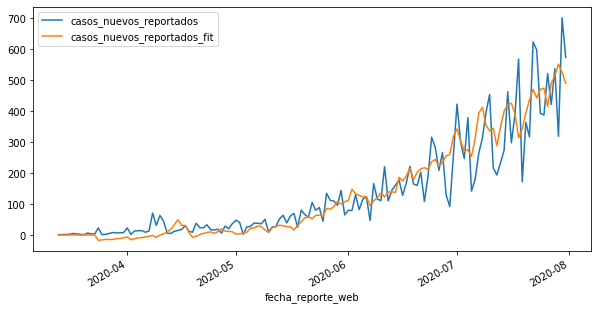

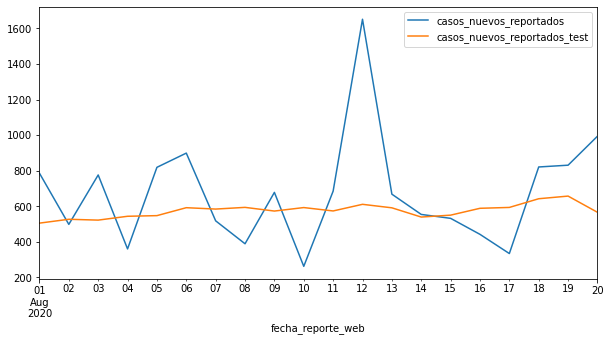

In [ ]:
plot=M2NuevosTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plot=M2NuevosTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2NuevosTrain['casos_nuevos_reportados'],M2NuevosTrain['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2NuevosTest['casos_nuevos_reportados'],M2NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)

MSE in train: 4355.330805
MSE in test: 97475.841426


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


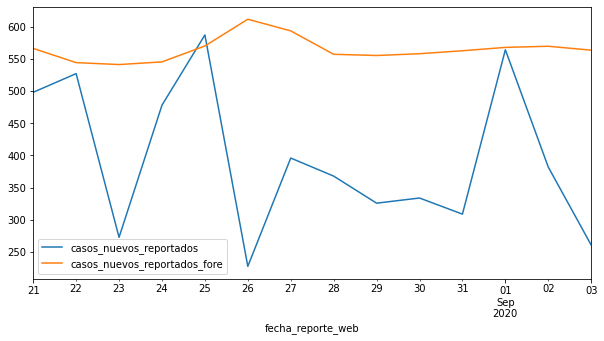

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2NuevosForecast['casos_nuevos_reportados_fore']=fore

plot=M2NuevosForecast[['casos_nuevos_reportados', 'casos_nuevos_reportados_fore']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


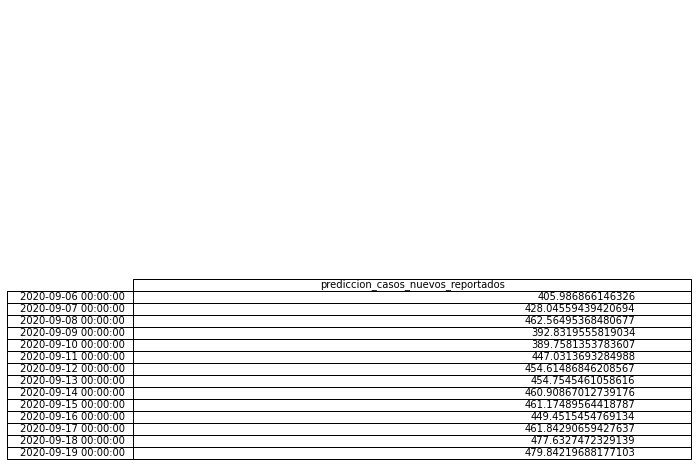

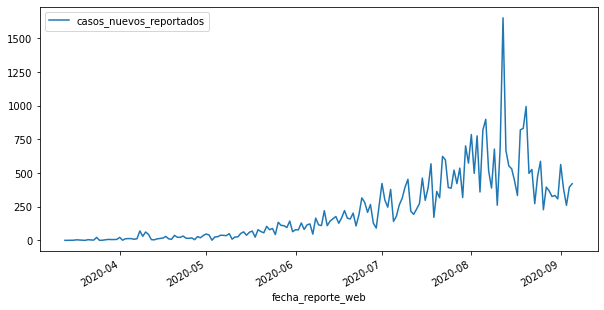

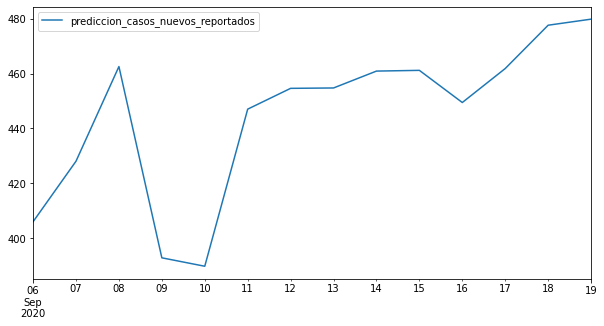

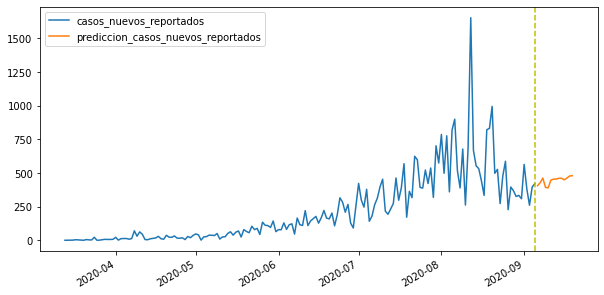

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Nuevos[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

from keras.models import load_model
model = load_model('ModCaliNuevos.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

CaliNuevos=sc.inverse_transform(b)

import datetime
index=[M2Nuevos.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
CaliNuevos=pd.DataFrame(data=CaliNuevos, index=index, columns=['prediccion_casos_nuevos_reportados'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, CaliNuevos) 
plt.savefig('./images/51.png')

M2Nuevos.plot().figure.savefig('./images/49.png')

CaliNuevos.plot().figure.savefig('./images/50.png')

total=pd.concat((M2Nuevos,CaliNuevos),axis = 0)
total.plot()
plt.axvline(x=M2Nuevos.index[-1],color='y',linestyle='--')
plt.savefig('./images/52.png')

CaliNuevos.to_excel('CaliNuevos.xlsx')

# Metodología 2: Muerte RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

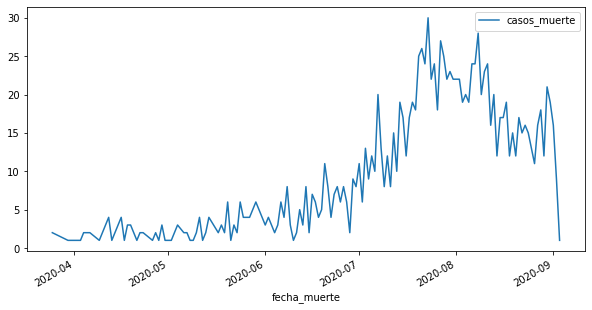

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M2Muerte.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2MuerteTrain=M2Muerte[:int(len(M2Muerte)*p_train)]
M2MuerteTest=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]
M2MuerteForecast=M2Muerte[int(len(M2Muerte)*(p_train+p_test)):]
print(M2Muerte.shape)
print(M2MuerteTrain.shape)
print(M2MuerteTest.shape)
print(M2MuerteForecast.shape)

(145, 1)
(116, 1)
(17, 1)
(12, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2MuerteTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2MuerteTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(109, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 20ms/step - loss: 0.1178
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0508
Epoch 3/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0548
Epoch 4/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0347
Epoch 5/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0313
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0131
Epoch 7/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0250
Epoch 8/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0190
Epoch 9/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0192
Epoch 10/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0132
Epoch 11/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0182
Epoch 12/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0125
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModCaliMuerte.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Muerte[:int(len(M2Muerte)*p_train)]
dataset_test=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2MuerteTrain['casos_muerte_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2MuerteTest['casos_muerte_test']=predicted

(17, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


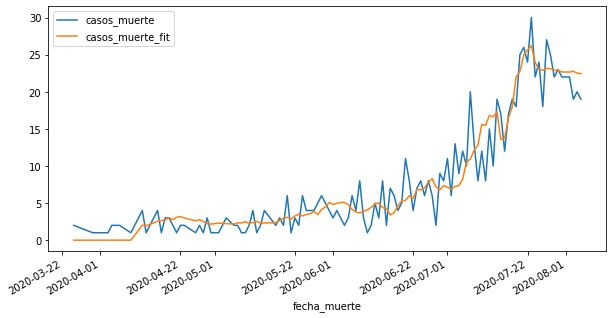

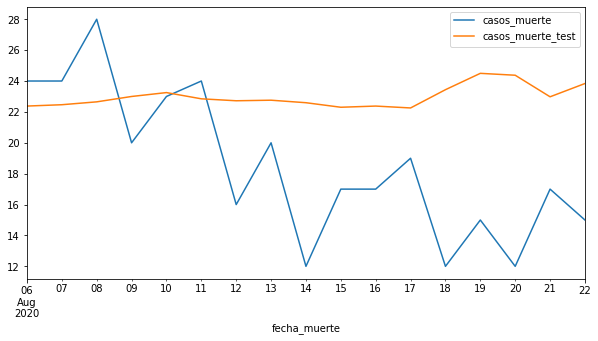

In [ ]:
plot=M2MuerteTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plot=M2MuerteTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2MuerteTrain['casos_muerte'],M2MuerteTrain['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2MuerteTest['casos_muerte'],M2MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 5.978560
MSE in test: 44.981977


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


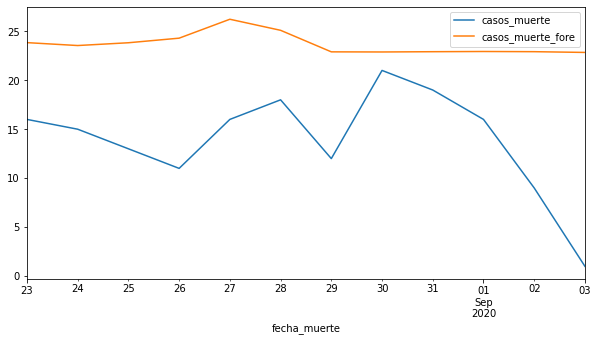

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,13):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2MuerteForecast['casos_muerte_fore']=fore

plot=M2MuerteForecast[['casos_muerte', 'casos_muerte_fore']].plot(figsize=(10, 5))

Terminé fallecidos


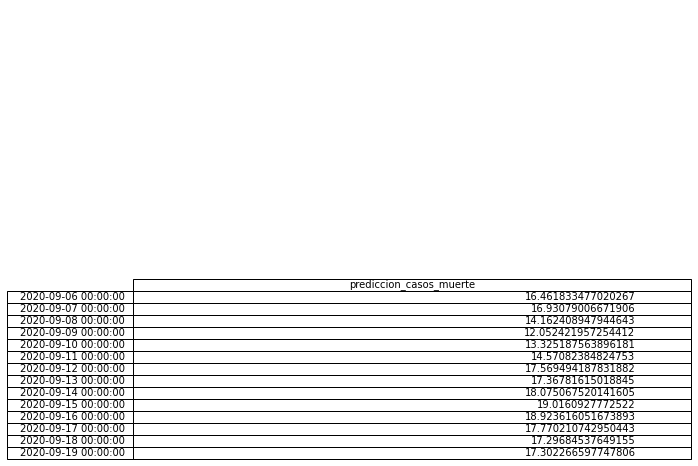

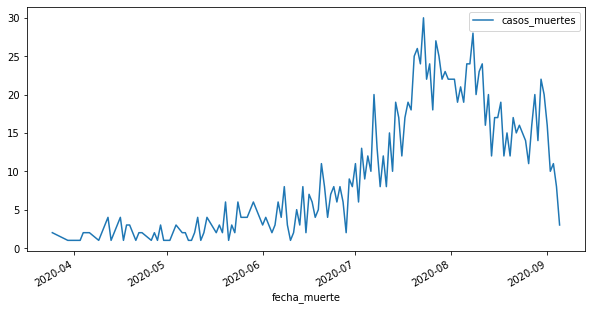

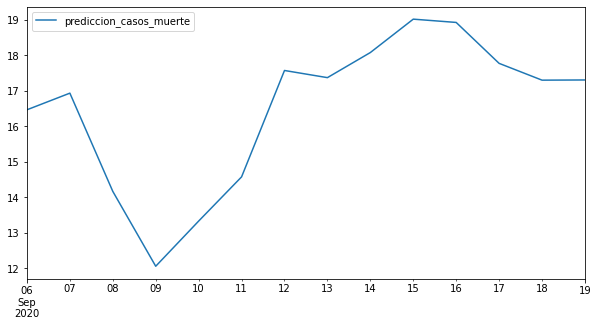

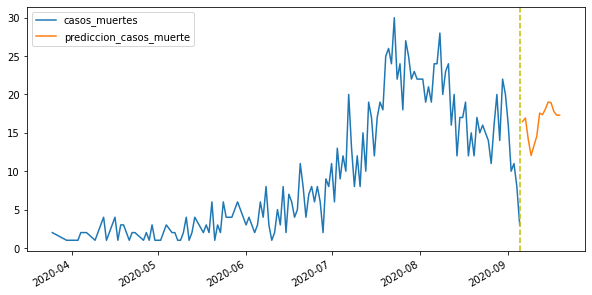

In [ ]:
# tabla con ciudades filtradas para modelar casos muerte
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muertes'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Muerte[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModCaliMuerte.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

CaliMuerte=sc.inverse_transform(b)

import datetime
index=[M2Muerte.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
CaliMuerte=pd.DataFrame(data=CaliMuerte, index=index, columns=['prediccion_casos_muerte'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, CaliMuerte) 
plt.savefig('images/55.png')

M2Muerte.plot().figure.savefig('images/53.png')

CaliMuerte.plot().figure.savefig('images/54.png')

total=pd.concat((M2Muerte,CaliMuerte),axis = 0)
total.plot()
plt.axvline(x=M2Muerte.index[-1],color='y',linestyle='--')
plt.savefig('images/56.png')

print("Terminé fallecidos")

CaliMuerte.to_excel('CaliMuerte.xlsx')


# Metodología 2: Recuperados RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

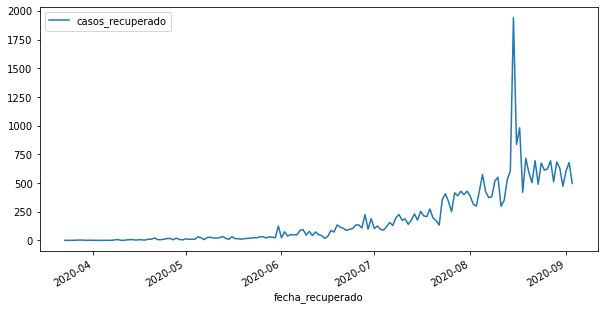

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M2Recuperado.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2RecuperadoTrain=M2Recuperado[:int(len(M2Recuperado)*p_train)]
M2RecuperadoTest=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]
M2RecuperadoForecast=M2Recuperado[int(len(M2Recuperado)*(p_train+p_test)):]
print(M2Recuperado.shape)
print(M2RecuperadoTrain.shape)
print(M2RecuperadoTest.shape)
print(M2RecuperadoForecast.shape)

(160, 1)
(128, 1)
(19, 1)
(13, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2RecuperadoTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2RecuperadoTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(121, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 21ms/step - loss: 0.1001
Epoch 2/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0555
Epoch 3/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0399
Epoch 4/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0211
Epoch 5/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0106
Epoch 6/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0226
Epoch 7/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0191
Epoch 8/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0098
Epoch 9/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0144
Epoch 10/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0119
Epoch 11/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0128
Epoch 12/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0107
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModCaliRecuperado.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Recuperado[:int(len(M2Recuperado)*p_train)]
dataset_test=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2RecuperadoTrain['casos_recuperado_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2RecuperadoTest['casos_recuperado_test']=predicted

(19, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


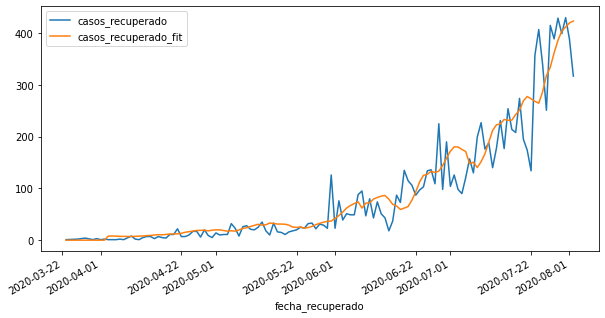

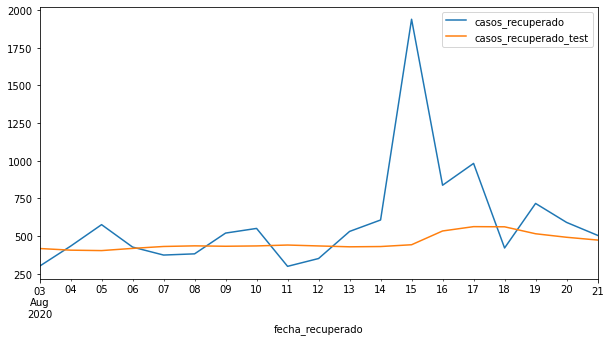

In [ ]:
plot=M2RecuperadoTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plot=M2RecuperadoTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2RecuperadoTrain['casos_recuperado'],M2RecuperadoTrain['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2RecuperadoTest['casos_recuperado'],M2RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)

MSE in train: 1464.260432
MSE in test: 143459.415181


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


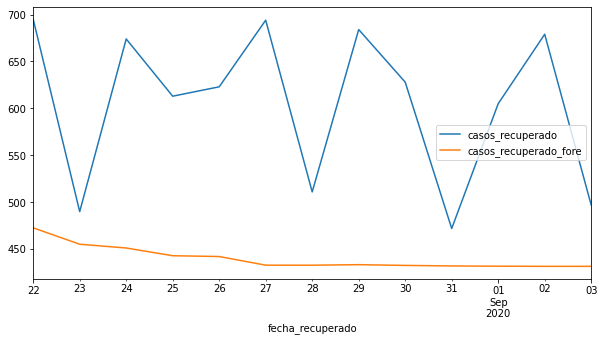

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,14):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2RecuperadoForecast['casos_recuperado_fore']=fore

plot=M2RecuperadoForecast[['casos_recuperado', 'casos_recuperado_fore']].plot(figsize=(10, 5))

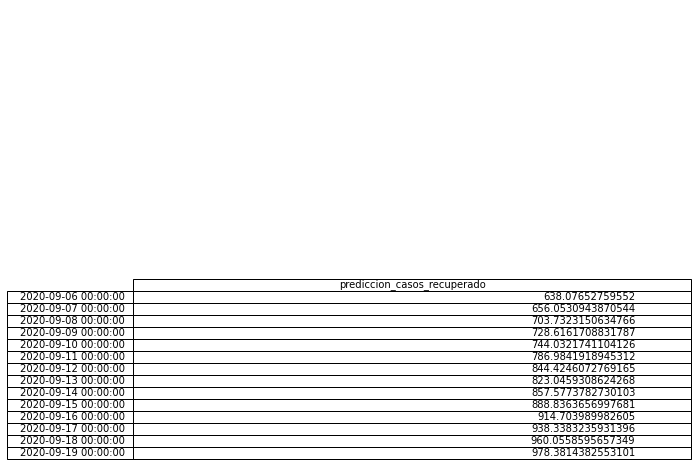

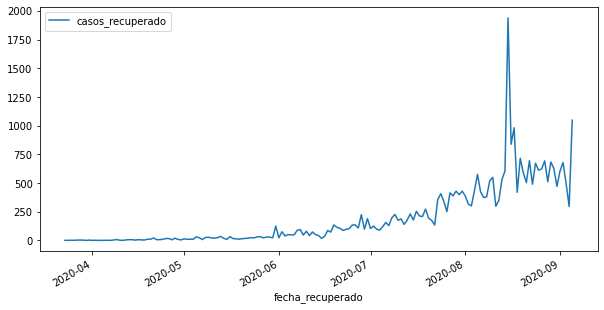

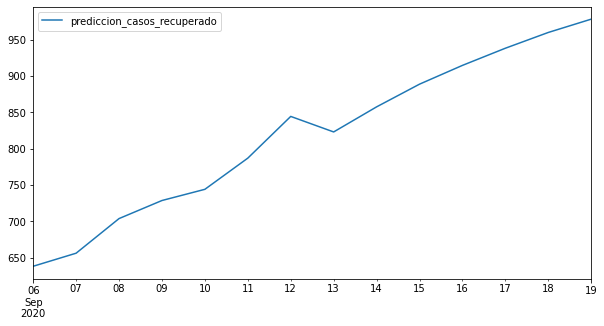

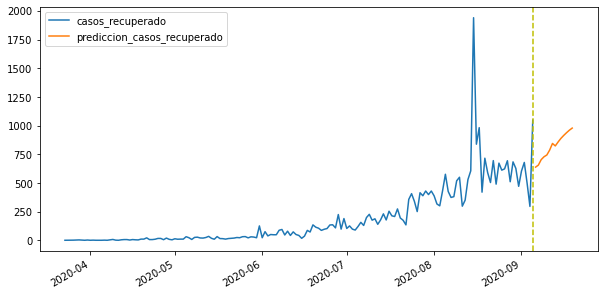

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperado
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Recuperado[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModCaliRecuperado.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

CaliRecuperado=sc.inverse_transform(b)

import datetime
index=[M2Recuperado.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
CaliRecuperado=pd.DataFrame(data=CaliRecuperado, index=index, columns=['prediccion_casos_recuperado'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, CaliRecuperado) 
plt.savefig('images/59.png')

M2Recuperado.plot().figure.savefig('images/57.png')

CaliRecuperado.plot().figure.savefig('images/58.png')

total=pd.concat((M2Recuperado,CaliRecuperado),axis = 0)
total.plot()
plt.axvline(x=M2Recuperado.index[-1],color='y',linestyle='--')
plt.savefig('images/60.png')

CaliRecuperado.to_excel('CaliRecuperado.xlsx')